In [1]:
from pystock.portfolio import Portfolio, Stock
from pystock.models import Model
import numpy as np
import os
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pio.renderers.default = "notebook"
pio.templates.default = "plotly_dark"
from frontier import EfficientFrontier
import warnings

warnings.filterwarnings('ignore')

# Creating Portfolio

In [2]:
stock_dir = "../../Data/Stocks/nasdaq200"
index_dir = "../../Data/Indices"

In [3]:
apple = Stock(directory=os.path.join(stock_dir, "AAPL.csv"), name="Apple")
google = Stock(directory=os.path.join(stock_dir, "GOOG.csv"), name="Google")
tesla = Stock(directory=os.path.join(stock_dir, "TSLA.csv"), name="Tesla")
microsoft = Stock(directory=os.path.join(stock_dir, "MSFT.csv"), name="Microsoft")

In [4]:
stocks = [apple, google, tesla, microsoft]
benchmark_dir = os.path.join(index_dir, "GSPC.csv")
p = Portfolio(benchmark_dir=benchmark_dir, benchmark_name="S&P 500")

In [5]:
p.add_stocks(stocks)

In [6]:
start_date = "2012-01-01"
end_date = "2022-12-01"
freq = "M"
p.load_all(start_date=start_date, end_date=end_date, frequency=freq, columns=["Adj Close"], rename_cols=["Close"])

In [7]:
p.load_benchmark(start_date=start_date, end_date=end_date, frequency=freq, columns=["Close"], rename_cols=["Close"])

In [8]:
for stock, name in p:
    print(stock.loaded, name)

True S&P 500
True Apple
True Google
True Tesla
True Microsoft


In [9]:
p.summary(frequency="M")

Portfolio Summary
*****************

Portfolio with benchmark S&P 500 and stocks ['Apple', 'Google', 'Tesla', 'Microsoft']
Here are the summary of stocks in the portfolio
+----+-----------+-----------------------+----------------------+------------+----------+----------+
|    | Stock     |   Monthly_Mean_Return |   Monthly_Return_STD |      Alpha |     Beta |   Weight |
|----+-----------+-----------------------+----------------------+------------+----------+----------|
|  0 | Apple     |             0.0222202 |             0.128892 | 0.008545   | 1.22705  |     0.25 |
|  1 | Google    |             0.020647  |             0.088315 | 0.00711404 | 1.04298  |     0.25 |
|  2 | Tesla     |             0.0468996 |             0.182335 | 0.0336704  | 1.72526  |     0.25 |
|  3 | Microsoft |             0.0235556 |             0.095769 | 0.010973   | 0.964346 |     0.25 |
+----+-----------+-----------------------+----------------------+------------+----------+----------+
The covariance matrix

# By Hand

In [10]:
m = Model("M")

In [11]:
m.add_portfolio(p, weights=[0.25, 0.25, 0.25, 0.25])

Adding portfolio...
Portfolio Summary
*****************

Portfolio with benchmark S&P 500 and stocks ['Apple', 'Google', 'Tesla', 'Microsoft']
Here are the summary of stocks in the portfolio
+----+-----------+-----------------------+----------------------+------------+----------+----------+
|    | Stock     |   Monthly_Mean_Return |   Monthly_Return_STD |      Alpha |     Beta |   Weight |
|----+-----------+-----------------------+----------------------+------------+----------+----------|
|  0 | Apple     |             0.0222202 |             0.128892 | 0.008545   | 1.22705  |     0.25 |
|  1 | Google    |             0.020647  |             0.088315 | 0.00711404 | 1.04298  |     0.25 |
|  2 | Tesla     |             0.0468996 |             0.182335 | 0.0336704  | 1.72526  |     0.25 |
|  3 | Microsoft |             0.0235556 |             0.095769 | 0.010973   | 0.964346 |     0.25 |
+----+-----------+-----------------------+----------------------+------------+----------+----------+
T

In [12]:
risk_free_rate = m.get_risk_free_rate()
risk_free_rate

0.3333333333333333

In [13]:
size = 20000
required_size = 8000
weights = np.random.uniform(low=-1.0, high=1.0,size=(size, len(m.portfolio)-1))
weights /= np.sum(weights, axis=1)[:, np.newaxis]
# weights = np.hstack((weights, np.ones((size, 1))))
weights.clip(min=-1, max=1, out=weights)
weights = weights[weights.sum(axis=1)==1]
if len(weights)<required_size:
    print("Not enough weights")
else:
    weights = weights[:required_size]
weights[0], len(weights)    

(array([ 0.72762913, -0.37973107,  0.59478263,  0.0573193 ]), 8000)

In [14]:
# required_size = 8000
# weights = np.random.uniform(low=0, high=1.0,size=(required_size, len(m.portfolio)-1))
# weights /= np.sum(weights, axis=1)[:, np.newaxis]
# weights.sum(axis=1)

In [15]:
returns = np.zeros(required_size)
volatilities = np.zeros(required_size)
sharpe_ratios = np.zeros(required_size)
for i in range(required_size):
    return_, variance, std = m.portfolio_info(weights[i], model="capm")
    returns[i] = return_
    volatilities[i] = variance
    sharpe_ratios[i] = (return_ - risk_free_rate) / std

In [16]:
tempelate = "Volatility deviation: %{x:.4f}%<br>Expected return: %{y:.4f}%"
for i, name in enumerate(m.portfolio.stock_names):
   tempelate+=f"<br>{name}: %{{customdata{[i]}:.4f}}%"

# print(tempelate)

In [17]:
fig = px.scatter(x=volatilities, y=returns, labels={"x": "Volatility", "y": "Return"}, custom_data=weights.T*100)
fig.update_traces(
    hovertemplate=tempelate,
    marker=dict(
        size=5,
        color=sharpe_ratios,
        colorscale="Viridis",
        showscale=True,
        colorbar=dict(title="Sharpe ratio"),
    ),
)
fig.show()

In [18]:
data = pd.DataFrame({"Volatility": volatilities, "Return": returns, "Sharpe ratio": sharpe_ratios})
data["Index"] = data.index
data.head()

Volatility    Return  Sharpe ratio  Index
0    2.284200  1.324909      0.656083      0
1    1.106702  1.025089      0.657563      1
2    1.095494  1.203015      0.830913      2
3    0.675336  1.068591      0.894704      3
4    1.868207  1.252964      0.672823      4

In [19]:
data["Return2"] = data["Return"].apply(lambda x: np.round(x, 3))
data.head()

Volatility    Return  Sharpe ratio  Index  Return2
0    2.284200  1.324909      0.656083      0    1.325
1    1.106702  1.025089      0.657563      1    1.025
2    1.095494  1.203015      0.830913      2    1.203
3    0.675336  1.068591      0.894704      3    1.069
4    1.868207  1.252964      0.672823      4    1.253

In [20]:
return_unique = data["Return2"].unique()
len(return_unique)

827

In [21]:
min_volatility = []
index = []
for i in return_unique:
    min_volatility.append(data[data["Return2"]==i]["Volatility"].min())
    index.append(data[data["Return2"]==i]["Volatility"].idxmin())

# for i in sharpe_ratios_unique:
#     min_volatility.append(data[data["Sharpe ratio2"]==i]["Volatility"].min())
#     index.append(data[data["Sharpe ratio2"]==i]["Volatility"].idxmin())

In [22]:
min_volatility = np.array(min_volatility)
index = np.array(index)
data_new = data.iloc[index]
data_new.head()

Volatility    Return  Sharpe ratio  Index  Return2
7179    2.281945  1.324550      0.656170   7179    1.325
7780    0.532932  1.024895      0.947316   7780    1.025
1547    1.061466  1.203035      0.844145   1547    1.203
379     0.585980  1.069200      0.961298    379    1.069
7490    1.374787  1.252670      0.784074   7490    1.253

In [23]:
data_new.sort_values(by="Return", inplace=True)

In [24]:
data_new["Return"].diff(1).max(), data_new["Return"].diff(1).min()

(0.018068756741342562, 2.5630539865373336e-05)

In [25]:
def remove_outliers(data, column):
    data = data.copy()
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[column] >= Q1 - 1.5 * IQR) & (data[column] <= Q3 + 1.5 * IQR)]
    return data

In [26]:
data_new["Return_Change"] = data_new["Return"].diff(1).fillna(0)
data_final = remove_outliers(data_new, "Return_Change")

In [39]:
data_final

Volatility    Return  Sharpe ratio  Index  Return2  Return_Change
3277    4.285778  0.552154      0.105700   3277    0.552       0.000000
7235    4.188024  0.563566      0.112503   7235    0.564       0.001684
4286    3.797302  0.612266      0.143140   4286    0.612       0.001080
3049    4.170650  0.613204      0.137043   3049    0.613       0.000938
3725    3.187213  0.614657      0.157580   3725    0.615       0.001453
...          ...       ...           ...    ...      ...            ...
3056    3.837910  1.488107      0.589453   3056    1.488       0.000634
4139    3.792057  1.489585      0.593766   4139    1.490       0.001478
1673    4.824023  1.491168      0.527159   1673    1.491       0.001582
4092    4.539067  1.543407      0.567974   4092    1.543       0.001110
1947    4.803644  1.544450      0.552587   1947    1.544       0.001043

[791 rows x 6 columns]

In [40]:
from scipy.interpolate import interp1d
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

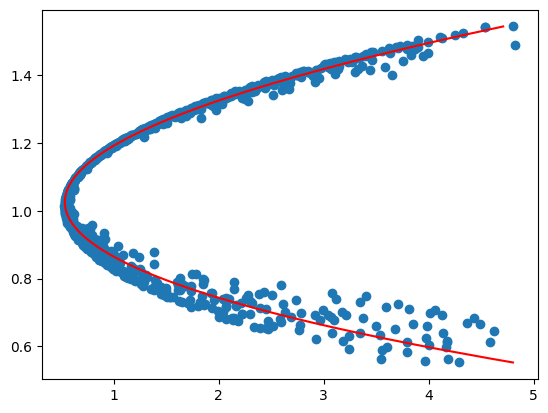

In [41]:
poly = PolynomialFeatures(3)
y = data_new["Volatility"].values
x = data_new["Return"].values
x_new = np.linspace(x.min(), x.max(), 200)
x_new = x_new.reshape(-1, 1)
x = x.reshape(-1, 1)
x_new_poly = poly.fit_transform(x_new)
x_poly = poly.fit_transform(x)
lr = LinearRegression()
lr.fit(x_poly, y)

y_new = lr.predict(x_poly)
y_new_new = lr.predict(x_new_poly)
# print
plt.scatter(y,x)
plt.plot(y_new, x, "r")
# plt.plot(y_new_new, x_new, "g")

In [58]:
np.concatenate([x**0, x**1, x**2, x**3], axis=1)

array([[1.        , 0.55215429, 0.30487437, 0.16833769],
       [1.        , 0.55764296, 0.31096567, 0.17340782],
       [1.        , 0.5618818 , 0.31571116, 0.17739236],
       ...,
       [1.        , 1.54229689, 2.37867971, 3.66863033],
       [1.        , 1.54340725, 2.38210594, 3.67655958],
       [1.        , 1.54444999, 2.38532576, 3.68401634]])

In [43]:
x_poly

array([[1.        , 0.55215429, 0.30487437, 0.16833769],
       [1.        , 0.55764296, 0.31096567, 0.17340782],
       [1.        , 0.5618818 , 0.31571116, 0.17739236],
       ...,
       [1.        , 1.54229689, 2.37867971, 3.66863033],
       [1.        , 1.54340725, 2.38210594, 3.67655958],
       [1.        , 1.54444999, 2.38532576, 3.68401634]])

In [30]:
data_new["Final_Return"] = x
data_new["Final_Volatility"] = y_new
data_new.head()

Volatility    Return  Sharpe ratio  Index  Return2  Return_Change  \
3277    4.285778  0.552154      0.105700   3277    0.552       0.000000   
337     3.966928  0.557643      0.112621    337    0.558       0.005489   
3438    3.550071  0.561882      0.121300   3438    0.562       0.004239   
7235    4.188024  0.563566      0.112503   7235    0.564       0.001684   
5158    3.790971  0.581635      0.127528   5158    0.582       0.018069   

      Final_Return  Final_Volatility  
3277      0.552154          4.802953  
337       0.557643          4.700373  
3438      0.561882          4.622072  
7235      0.563566          4.591181  
5158      0.581635          4.267713

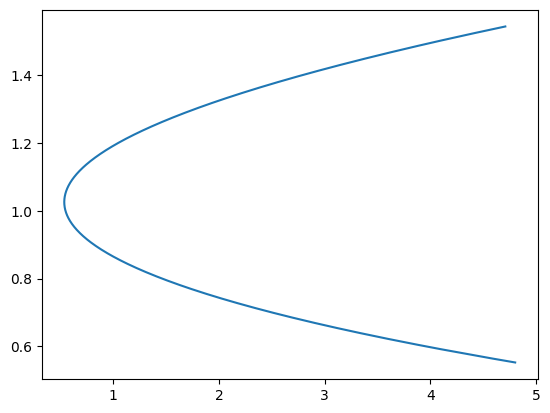

In [31]:
plt.plot(data_new["Final_Volatility"], data_new["Final_Return"])

In [32]:
weights_final = weights[index]

In [33]:
customdata = weights_final.T*100

In [34]:

fig = px.line(x=data_new["Final_Volatility"], y=data_new["Final_Return"], labels={"x": "Volatility", "y": "Return"}, custom_data=weights_final.T*100)
fig.update_traces(
    hovertemplate=tempelate,
    marker=dict(
        size=5,
        color=sharpe_ratios,
        colorscale="Viridis",
        showscale=True,
        colorbar=dict(title="Sharpe ratio"),
    ),
)
fig.show()

In [35]:
class CurveFitting:
    """
    A class to implement mth order polynomial regression using the least squares method.

    Use the `fit` method to fit the model. Then predict the Y values given X values using\\
    the `predict` method.

    """

    def __init__(self) -> None:
        self.beta = None
        self.stats = None

    def fit(self, X, Y, order=3, plot=False, stats=True):
        """
        Polynomial regression of order m using least squares method.

        Parameters
        ----------
        X : array_like
            Independent variable.
        Y : array_like
            Dependent variable.
        order : int, optional
            Order of the polynomial. Default is 3.
        plot : bool, optional
            If True, plot the regression line. Default is True.
        statistics : bool, optional
            If True, return the statistics. Default is True.

        Returns
        -------
        beta : array_like
            Coefficients of the polynomial regression model.
        stats : dict
            Statistics of the polynomial regression model.
            `r2` : square of correlation coefficient
            `syx` : standard error of the estimate
        """
        self.n = len(X)
        Xis = np.zeros(2 * order + 1)
        Yis = np.zeros(order + 1)
        for i in range(0, 2 * order + 1):
            if i == 0:
                Xis[i] = self.n
                continue
            xi = np.sum(X ** i)
            Xis[i] = xi

        for i in range(1, order + 2):
            yi = np.sum(Y * (X ** (i - 1)))
            Yis[i - 1] = yi
        A = np.zeros((order + 1, order + 1))
        for i in range(0, order + 1):
            A[i] = Xis[i : i + order + 1]
        beta = np.linalg.solve(A, Yis)
        self.beta = beta

        if plot:
            X_l = np.linspace(np.min(X) - np.std(X), np.max(X) + np.std(X), 100)

            def predict(X_l):
                Y_l = 0
                for i in range(0, order + 1):
                    Y_l += beta[i] * X_l ** i
                return Y_l

            Y_l = predict(X_l)
            plt.figure(figsize=(10, 8))
            plt.scatter(X, Y)
            plt.plot(X_l, Y_l, "r")
            plt.xlim(np.min(X) - np.std(X), np.max(X) + np.std(X))
            plt.ylim(np.min(Y) - np.std(Y), np.max(Y) + np.std(Y))
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.show()

        if stats:
            ymean = np.mean(Y)
            y_pred = self.predict(X)
            Sr = np.sum((Y - y_pred) ** 2)
            SYX = np.sqrt(Sr / (self.n - order - 1))
            # r2
            r2 = (np.sum((Y - ymean) ** 2) - Sr) / (np.sum((Y - ymean) ** 2))
            stats = {"r2": r2, "syx": SYX}
            self.stats = stats
            return beta, stats
        else:
            return beta

    def predict(self, X_l):
        """
        Predict the Y values given X values.

        Parameters
        ----------
        X_l : array_like
            Independent variable.

        Returns
        -------
        Y_l : array_like
            Predicted Y values.
        """
        Y_l = np.zeros(len(X_l))
        for i in range(0, len(self.beta)):
            Y_l += self.beta[i] * X_l ** i
        return Y_l

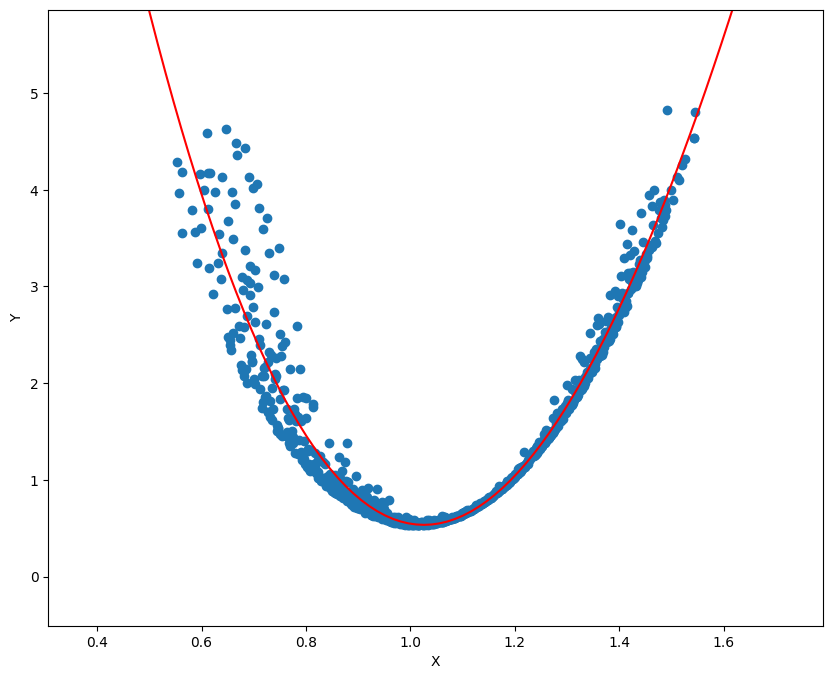

In [60]:
cf = CurveFitting()
beta, stat = cf.fit(Y=data_new["Volatility"], X=data_new["Return"], order=3, plot=True, stats=True)

In [61]:
beta

array([ 22.60405239, -46.74347932,  28.21839222,  -3.53189479])

In [62]:
stat

{'r2': 0.9287982361930327, 'syx': 0.27744663356343635}

# EF

In [10]:
ef = EfficientFrontier(portfolio=p)

Adding portfolio...
Portfolio Summary
*****************

Portfolio with benchmark S&P 500 and stocks ['Apple', 'Google', 'Tesla', 'Microsoft']
Here are the summary of stocks in the portfolio
+----+-----------+-----------------------+----------------------+------------+----------+----------+
|    | Stock     |   Monthly_Mean_Return |   Monthly_Return_STD |      Alpha |     Beta |   Weight |
|----+-----------+-----------------------+----------------------+------------+----------+----------|
|  0 | Apple     |             0.0222202 |             0.128892 | 0.008545   | 1.22705  |     0.25 |
|  1 | Google    |             0.020647  |             0.088315 | 0.00711404 | 1.04298  |     0.25 |
|  2 | Tesla     |             0.0468996 |             0.182335 | 0.0336704  | 1.72526  |     0.25 |
|  3 | Microsoft |             0.0235556 |             0.095769 | 0.010973   | 0.964346 |     0.25 |
+----+-----------+-----------------------+----------------------+------------+----------+----------+
T

In [11]:
ef.plot_frontier()

Not enough weights. Continuing...


ValueError: All arguments should have the same length. The length of argument `custom_data_0` is 736, whereas the length of  previously-processed arguments ['x', 'y'] is 690